In [1]:
import sampleClient
import realsense_sensor as sensor
import cv2
import os
import matplotlib.pyplot as plt
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass

/home/ralfi/git/cv_pipeline


In [2]:
cam = sensor.RealsenseSensor("cfg/sensors/realsense_config.json")
cam.start()

2019-09-05 12:43:39.250 | INFO     | realsense_sensor:__init__:54 - Cam <pyrealsense2.device: Intel RealSense D435 (S/N: 920312072048)> connected.
2019-09-05 12:43:41.582 | INFO     | realsense_sensor:start:98 - Realsense stream started.
2019-09-05 12:43:41.583 | INFO     | realsense_sensor:start:99 - Advanced mode is True


In [6]:
img, d = cam.frames()

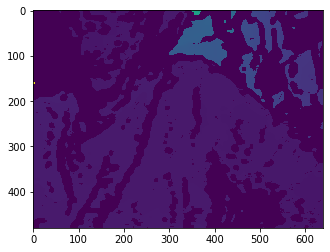

In [7]:
plt.imshow(d)

In [8]:
intrinsics = {
    "cx": cam._intrinsics.ppx,
    "cy": cam._intrinsics.ppy,
    "fx": cam._intrinsics.fx,
    "fy": cam._intrinsics.fy
}
print(intrinsics)

{'cx': 322.43145751953125, 'cy': 252.92642211914062, 'fx': 613.5696411132812, 'fy': 613.9479370117188}


In [ ]:
print(np.shape(d))

In [ ]:
segmask = sampleClient.predictMask(d, **intrinsics)

In [ ]:
sampleClient.predictGQCNN_pj(img_bgr, d, **intrinsics)

In [ ]:
sampleClient.predictFCGQCNN_pj(img_bgr, d, segmask['masks'][0], **intrinsics)

In [3]:
cam.stop()

True